In [32]:
import sys
sys.path.append('/Users/mehmetbezcioglu/Documents/SEMESTER1/DeepLearning/one_shot_learning/image_similarity')
from networks.siamese import MNIST
from datasets import Loader
import tensorflow as tf
import numpy as np
import cv2
from bin.utils import plot,get_val_acc
import matplotlib.pyplot as plt

# Build the model

In [2]:
tf.reset_default_graph()
nn = MNIST(shape=(35,35))
nn.forward_prop()
nn.compute_cost(mode="l2_on")
nn.optimize("Momentum")
nn.accuracy()

In [3]:
print(nn)
print(nn.cost)
print(nn.accuracy)
print(nn.optimizer)
nn.predicted_labels

<MNIST:
 CONV_1: Tensor("Relu_4:0", shape=(?, 33, 33, 96), dtype=float32)
 POOL_1: Tensor("MaxPool_2:0", shape=(?, 16, 16, 96), dtype=float32)
 CONV_2: Tensor("Relu_5:0", shape=(?, 12, 12, 256), dtype=float32)
 POOL_2: Tensor("MaxPool_3:0", shape=(?, 6, 6, 256), dtype=float32)
 CONV_3: Tensor("Relu_6:0", shape=(?, 4, 4, 256), dtype=float32)
 FLATTENED:Tensor("transpose_1:0", shape=(4096, ?), dtype=float32)
>
Tensor("Mean:0", shape=(), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32)
[<tf.Operation 'Momentum' type=NoOp>, <tf.Operation 'Momentum_1' type=NoOp>, <tf.Operation 'Momentum_2' type=NoOp>, <tf.Operation 'Momentum_3' type=NoOp>, <tf.Operation 'Momentum_4' type=NoOp>]


<tf.Tensor 'Greater:0' shape=(1, ?) dtype=bool>

# Scale the dataset

In [4]:
data = Loader(n_examples=20,mode=None,normalise=True)

19280
(964, 20, 105, 105, 1)


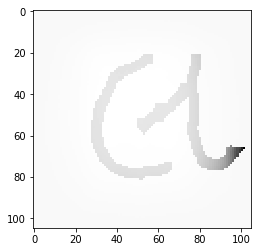

(105, 105, 1)

In [21]:
plot(data.X[0,0].reshape(105,105))
data.X[0,0].shape

# Scale one image

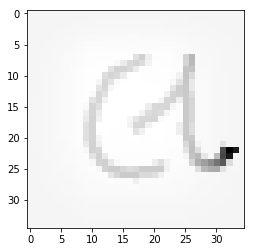

(35, 35, 1)

In [23]:
img_rescaled = cv2.resize(data.X[0,0],(35,35),interpolation=cv2.INTER_AREA).reshape(35,35,1)
plt.imshow(img_rescaled.reshape(35,35),cmap='gray')
plt.show()
img_rescaled.shape

# Scale the rest of the dataset

In [ ]:
# data.X.reshape().shape
data.X = data.X.reshape(-1,105,105)
# data.X.shape
for idx in range(data.X.shape[0]):
    data.X[idx] = cv2.resize(data.X[idx],(35,35),interpolation=cv2.INTER_AREA).reshape(35,35,1)

In [ ]:
print(data.X.shape)

# Train the model

In [42]:
def calc_one_shot_acc(nn,sess,test_data,val_data,n_trials_per_iter,n_trials):
    val_acc = 0
    one_shot_acc = 0
    for _ in range(n_trials // n_trials_per_iter): 
        test_imgs, train_imgs, labels = test_data.generateOneShotTrials(test_data.X_validation,size=n_trials_per_iter)          
        val_acc += utils.get_val_acc(test_imgs,train_imgs,labels,sess,nn,shape=(35,35))
        one_shot_test_imgs, one_shot_train_imgs, one_shot_labels = val_data.generateOneShotTrials(val_data.X,size=n_trials_per_iter)          
        one_shot_acc += utils.get_val_acc(one_shot_test_imgs,one_shot_train_imgs,one_shot_labels,sess,nn,shape=(35,35))
    return val_acc/ n_trials, one_shot_acc/ n_trials

In [43]:
def display_data(epoch,epoch_loss,epoch_acc,val_acc,one_shot_acc):
    print("Epoch:{}\t Epoch Loss:{}\t Train acc:{} \t Val acc:{}\t One Shot acc:{}".format(epoch,epoch_loss,epoch_acc,val_acc,one_shot_acc))
    print('{{"metric" : "Loss", "value":{}}}'.format(epoch_loss))
    print('{{"metric" : "Training Accuracy", "value":{}}}'.format(epoch_acc))
    print('{{"metric" : "Validation Accuracy", "value":{}}}'.format(val_acc))
    print('{{"metric" : "One-shot Accuracy", "value":{}}}'.format(one_shot_acc))

In [44]:
def train(nn,hyperparameters,train_data,test_data,val_data,epochs,batch_size,drawer_size):
    saver = tf.train.Saver()
    filepath = "/output/conv_siamese_model"
    seed = 1 
    n_trials = 400
    n_trials_per_iter = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # saver.restore(sess,"/floyd/input/model/conv_siamese_model_40.ckpt")
        # print("conv_siamese_model_40.ckpt is restored.")
        for epoch in range(epochs+1):
            epoch_loss = 0
            epoch_acc = 0
            training_batch = train_data.get_training_pairs(batch_size= batch_size, drawer_size= drawer_size, seed=seed)
            seed += ((train_data.X.shape[0] * train_data.X.shape[1]) // training_batch[0][0].shape[0])       
            for counter, batch in enumerate(training_batch):
                X1 = batch[0]
                X2 = batch[1]
                Y  = batch[2]
                _, c, a= sess.run([nn.optimizer,nn.cost,nn.accuracy], feed_dict={
                    nn.X:  X1,
                    nn.X2: X2,
                    nn.Y:  Y,
                    nn.learning_rates[0]:hyperparameters[0]   * (0.99** epoch),#0.5
                    nn.learning_rates[1]:hyperparameters[1] * (0.99** epoch),
                    nn.learning_rates[2]:hyperparameters[2]  * (0.99** epoch),
                    nn.learning_rates[3]:hyperparameters[3]  * (0.99** epoch),
                    nn.learning_rates[4]:hyperparameters[4]  * (0.99** epoch),
                    nn.momentums[0]:hyperparameters[6]  * (1.01** epoch),
                    nn.momentums[1]:hyperparameters[7]  * (1.01** epoch),
                    nn.momentums[2]:hyperparameters[8]  * (1.01** epoch),
                    nn.momentums[3]:hyperparameters[9]  * (1.01** epoch),
                    nn.momentums[4]:hyperparameters[10]  * (1.01** epoch)
                })
                epoch_acc += (a/len(training_batch))
                epoch_loss += (c/ len(training_batch))
            val_acc, one_shot_acc = calc_one_shot_acc(nn,sess,test_data,val_data,n_trials_per_iter,n_trials)
            display_data(epoch,epoch_loss,epoch_acc,val_acc,one_shot_acc)
            if ((epoch % 10 == 0) and epoch != 0):
                print("Saving the model...")
                saver.save(sess,filepath + "_" + str(epoch) + ".ckpt")
    return one_shot_acc

In [45]:
train_data = Loader(n_examples=100,mode="train_split",path="/floyd/input/omniglot_dataset",normalise= True)
test_data  = Loader(n_examples=20,mode=None,path="/floyd/input/val_set",normalise=True) 
hyperparameters = [
                    0.1,
                    0.1,
                    0.1,
                    0.05,
                    0.01,
                    0.5,
                    0.5,
                    0.5,
                    0.5,
                    0.5
          ]
acc = train(nn,hyperparameters,train_data,train_data,test_data,epochs=100,batch_size=128,drawer_size=2)
print("Final one shot accuracy:{}".format(acc))

0


IndexError: tuple index out of range